In [37]:
!pip install haversine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from haversine import haversine
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import LearningCurveDisplay

In [2]:
from google.cloud import bigquery

In [3]:
client = bigquery.Client()

In [4]:

query = """ SELECT * FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE pickup_latitude IS NOT NULL
AND pickup_longitude IS NOT NULL
AND dropoff_latitude IS NOT NULL
AND dropoff_longitude IS NOT NULL
AND trip_miles IS NOT NULL
LIMIT 20000
"""

In [5]:
df = client.query(query).result().to_dataframe()
df

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,dffca9de0ffa5179659d9d057713e2a81ba99402,fe806ca7a45786db86ed61fe4c027b1f5a5a4b5c9f3595...,2014-04-22 06:15:00+00:00,2014-04-22 06:30:00+00:00,720,3.3,<NA>,<NA>,35,32,...,0.0,11.05,Cash,None,41.835118,-87.618678,POINT (-87.6186777673 41.8351179863),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
1,af54e0f4d9d86a935bed898fe76145521ab6ff5e,adb0da2862924ceb2be34ffd2eab0a097a8e6594c39415...,2019-03-25 08:15:00+00:00,2019-03-25 08:30:00+00:00,780,2.3,17031081000,17031281900,8,28,...,0.0,10.00,Cash,Star North Management LLC,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
2,e4e0612a572f43fae125ab73bc8c2c7d644921c7,89ef5c25a11357447e27d929bb434fd12122184b1ebe5e...,2019-03-09 19:15:00+00:00,2019-03-09 19:45:00+00:00,1320,0.3,<NA>,<NA>,22,8,...,0.0,17.50,Cash,Taxi Affiliation Services,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,428e8ede2b45110eb269ff7ffb34fced9d4b0ead,160e925d844527c4f474ca64ac3e53630abf5b61d364a6...,2019-03-22 19:45:00+00:00,2019-03-22 19:45:00+00:00,360,1.3,<NA>,<NA>,1,77,...,1.0,7.50,Cash,Taxi Affiliation Services,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999)
4,8cf4dcaf7c75a0a28cf69775600141727e63fb79,c1e85fc2bb426ec4ca690022e681a24ed4c06c04b992a1...,2019-03-28 12:00:00+00:00,2019-03-28 12:15:00+00:00,540,1.6,17031080202,17031320100,8,32,...,0.0,8.00,Cash,Taxi Affiliation Services,41.905858,-87.630865,POINT (-87.6308650266 41.9058577688),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,75dad85cd960f7c40dc56f8f5cecd8795ed544e3,cce8c54f19d692acc5dd45d391a8bb964d15af67f314d1...,2019-03-28 19:15:00+00:00,2019-03-28 19:30:00+00:00,540,0.8,17031280100,17031081600,28,8,...,1.0,9.75,Credit Card,Taxi Affiliation Services,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347)
19996,6b72cf445d8fb5e2b09f8b42c8cda4f8df15336b,f079326e91f3293e6376e27666a6b16ebc93924d29469b...,2019-03-11 08:45:00+00:00,2019-03-11 09:00:00+00:00,720,1.9,17031280100,17031081201,28,8,...,0.0,9.50,Cash,Star North Management LLC,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134)
19997,5f80589e94fa5689178fa7f31633f657b94b9ee5,6e592d9c29711b8c0dc5888508b382bd0b75de5469930e...,2019-03-27 21:00:00+00:00,2019-03-27 21:00:00+00:00,420,0.0,17031280100,17031839000,28,32,...,0.0,10.00,Credit Card,Taxi Affiliation Services,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.871016,-87.631407,POINT (-87.6314065252 41.8710158803)
19998,bc2abac9d29df5eb09836fe4cb4385c42afe6196,43946e4da8905d64ceeed7cfc2b1969df72ecf991b865a...,2019-03-25 19:15:00+00:00,2019-03-25 19:30:00+00:00,360,0.0,17031280100,17031833000,28,28,...,0.0,6.00,Cash,"Taxicab Insurance Agency, LLC",41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201)


In [6]:
df.shape

(20000, 23)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              20000 non-null  object             
 1   taxi_id                 20000 non-null  object             
 2   trip_start_timestamp    20000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp      20000 non-null  datetime64[ns, UTC]
 4   trip_seconds            19999 non-null  Int64              
 5   trip_miles              20000 non-null  float64            
 6   pickup_census_tract     14076 non-null  Int64              
 7   dropoff_census_tract    14076 non-null  Int64              
 8   pickup_community_area   19999 non-null  Int64              
 9   dropoff_community_area  19930 non-null  Int64              
 10  fare                    19996 non-null  float64            
 11  tips                    19996 non-null  f

In [8]:
# Convert the datetime column to datetime dtype
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

# Convert datetime values to the desired format
df['trip_start_timestamp'] = df['trip_start_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [9]:
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,dffca9de0ffa5179659d9d057713e2a81ba99402,fe806ca7a45786db86ed61fe4c027b1f5a5a4b5c9f3595...,2014-04-22 06:15:00,2014-04-22 06:30:00+00:00,720,3.3,<NA>,<NA>,35,32,...,0.0,11.05,Cash,None,41.835118,-87.618678,POINT (-87.6186777673 41.8351179863),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
1,af54e0f4d9d86a935bed898fe76145521ab6ff5e,adb0da2862924ceb2be34ffd2eab0a097a8e6594c39415...,2019-03-25 08:15:00,2019-03-25 08:30:00+00:00,780,2.3,17031081000,17031281900,8,28,...,0.0,10.00,Cash,Star North Management LLC,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
2,e4e0612a572f43fae125ab73bc8c2c7d644921c7,89ef5c25a11357447e27d929bb434fd12122184b1ebe5e...,2019-03-09 19:15:00,2019-03-09 19:45:00+00:00,1320,0.3,<NA>,<NA>,22,8,...,0.0,17.50,Cash,Taxi Affiliation Services,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,428e8ede2b45110eb269ff7ffb34fced9d4b0ead,160e925d844527c4f474ca64ac3e53630abf5b61d364a6...,2019-03-22 19:45:00,2019-03-22 19:45:00+00:00,360,1.3,<NA>,<NA>,1,77,...,1.0,7.50,Cash,Taxi Affiliation Services,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999)
4,8cf4dcaf7c75a0a28cf69775600141727e63fb79,c1e85fc2bb426ec4ca690022e681a24ed4c06c04b992a1...,2019-03-28 12:00:00,2019-03-28 12:15:00+00:00,540,1.6,17031080202,17031320100,8,32,...,0.0,8.00,Cash,Taxi Affiliation Services,41.905858,-87.630865,POINT (-87.6308650266 41.9058577688),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)


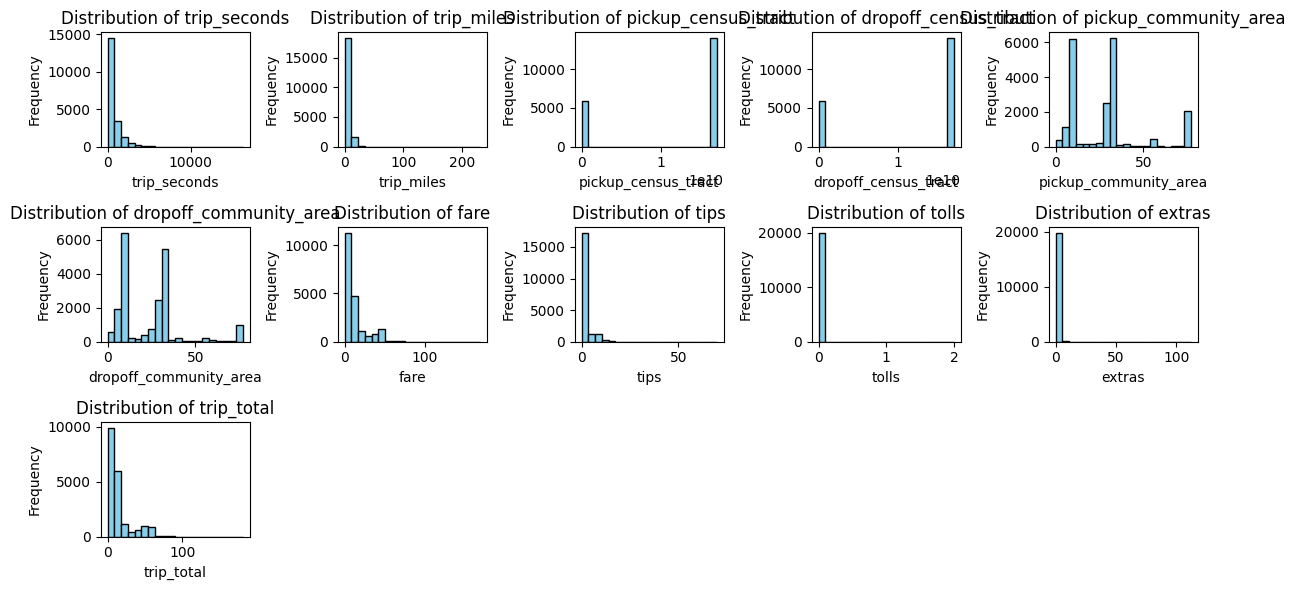

In [15]:
test_df = df
test_df.fillna(0, inplace=True)

features = ['trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total']

num_features = len(features)
num_cols = 5
num_rows = (num_features - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, feature in enumerate(features):
    row_index = i // num_cols
    col_index = i % num_cols

    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    ax.hist(df[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

In [10]:
to_drop = ["taxi_id",
           "pickup_census_tract",
           "dropoff_census_tract",
           "tips",
           "trip_seconds",
           "trip_miles",
           "extras",
           "trip_total",
           "company",
           "tolls",
           "payment_type",
           "trip_end_timestamp"]

# Drop selected fields in place
df.drop(to_drop, inplace=True, axis=1)

In [11]:
df.head()

,unique_key,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,ac47bdc660588b47d63d50b581a232fdf8c747ab,2018-10-09 18:00:00,8,32,12.50,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724)
1,49df974e508731ec13b5bd649f08d866eb3dd814,2018-10-24 16:45:00,41,33,15.50,41.794090,-87.592311,POINT (-87.592310855 41.794090253),41.857184,-87.620335,POINT (-87.6203346241 41.8571838585)
2,6e3805494f154e878aaa1d1e4f4b9607155437bc,2018-10-26 18:45:00,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967)
3,c1a76c9d5bf607bdf664d0c10c16537920b0d8bf,2018-10-09 11:45:00,11,11,5.50,41.978830,-87.771167,POINT (-87.771166703 41.9788295262),41.978830,-87.771167,POINT (-87.771166703 41.9788295262)
4,c92b6caaa4711acf4b585d6962de26c757c2625c,2018-10-18 22:15:00,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unique_key              20000 non-null  object 
 1   trip_start_timestamp    20000 non-null  object 
 2   pickup_community_area   19999 non-null  Int64  
 3   dropoff_community_area  19931 non-null  Int64  
 4   fare                    20000 non-null  float64
 5   pickup_latitude         20000 non-null  float64
 6   pickup_longitude        20000 non-null  float64
 7   pickup_location         20000 non-null  object 
 8   dropoff_latitude        20000 non-null  float64
 9   dropoff_longitude       20000 non-null  float64
 10  dropoff_location        20000 non-null  object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.7+ MB


In [13]:
df.drop(columns=['unique_key'], inplace=True, axis=1)
df.head()

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,2018-10-09 18:00:00,8,32,12.50,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724)
1,2018-10-24 16:45:00,41,33,15.50,41.794090,-87.592311,POINT (-87.592310855 41.794090253),41.857184,-87.620335,POINT (-87.6203346241 41.8571838585)
2,2018-10-26 18:45:00,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967)
3,2018-10-09 11:45:00,11,11,5.50,41.978830,-87.771167,POINT (-87.771166703 41.9788295262),41.978830,-87.771167,POINT (-87.771166703 41.9788295262)
4,2018-10-18 22:15:00,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)


In [14]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['weekday'] = df['trip_start_timestamp'].map(lambda x: x.weekday())
df['time'] = df['trip_start_timestamp'].map(lambda x: x.hour*4 + round(x.minute/15))

df.head()

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time
0,2018-10-09 18:00:00,8,32,12.50,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),1,72
1,2018-10-24 16:45:00,41,33,15.50,41.794090,-87.592311,POINT (-87.592310855 41.794090253),41.857184,-87.620335,POINT (-87.6203346241 41.8571838585),2,67
2,2018-10-26 18:45:00,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),4,75
3,2018-10-09 11:45:00,11,11,5.50,41.978830,-87.771167,POINT (-87.771166703 41.9788295262),41.978830,-87.771167,POINT (-87.771166703 41.9788295262),1,47
4,2018-10-18 22:15:00,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),3,89


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_community_area   19999 non-null  Int64         
 2   dropoff_community_area  19931 non-null  Int64         
 3   fare                    20000 non-null  float64       
 4   pickup_latitude         20000 non-null  float64       
 5   pickup_longitude        20000 non-null  float64       
 6   pickup_location         20000 non-null  object        
 7   dropoff_latitude        20000 non-null  float64       
 8   dropoff_longitude       20000 non-null  float64       
 9   dropoff_location        20000 non-null  object        
 10  weekday                 20000 non-null  int64         
 11  time                    20000 non-null  int64         
dtypes: Int64(2), datetime64[ns](1), float64(5), in

In [16]:
df

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time
0,2018-10-09 18:00:00,8,32,12.50,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),1,72
1,2018-10-24 16:45:00,41,33,15.50,41.794090,-87.592311,POINT (-87.592310855 41.794090253),41.857184,-87.620335,POINT (-87.6203346241 41.8571838585),2,67
2,2018-10-26 18:45:00,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),4,75
3,2018-10-09 11:45:00,11,11,5.50,41.978830,-87.771167,POINT (-87.771166703 41.9788295262),41.978830,-87.771167,POINT (-87.771166703 41.9788295262),1,47
4,2018-10-18 22:15:00,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),3,89
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2018-10-26 19:00:00,28,32,5.50,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4,76
19996,2018-10-18 17:45:00,28,56,31.50,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.785999,-87.750934,POINT (-87.7509342894 41.785998518),3,71
19997,2018-10-26 13:30:00,28,8,7.25,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),4,54
19998,2018-10-19 08:30:00,28,32,5.50,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4,34


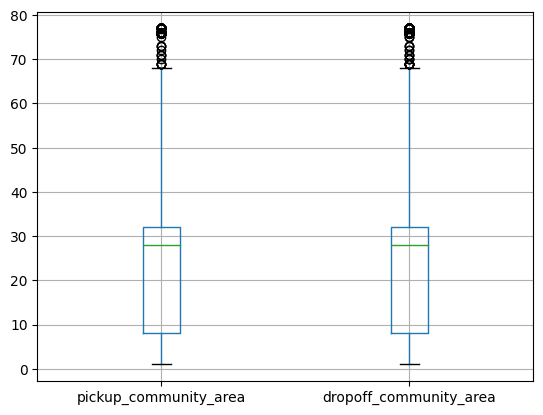

In [17]:
boxplot = df.boxplot(column=['pickup_community_area','dropoff_community_area'])

In [18]:
df.dropna(inplace=True)
df.shape

(19931, 12)

In [19]:
# Calculate the median
median_pickup = df['pickup_community_area'].median()
median_dropoff = df['dropoff_community_area'].median()

In [20]:
# Winsorization for pickup_community_area
data_pickup = df['pickup_community_area']
lower_limit_pickup = np.percentile(data_pickup, 5)  
upper_limit_pickup = np.percentile(data_pickup, 90)  

df['pickup_community_area'] = np.where((data_pickup < lower_limit_pickup) | (data_pickup > upper_limit_pickup), median_pickup, data_pickup)

# Updated boxplot with outliers replaced by median
# updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [21]:
# Winsorization for dropoff_community_area
data_dropoff = df['dropoff_community_area']
lower_limit_dropoff = np.percentile(data_dropoff, 5)  
upper_limit_dropoff = np.percentile(data_dropoff, 90)  

df['dropoff_community_area'] = np.where((data_dropoff < lower_limit_dropoff) | (data_dropoff > upper_limit_dropoff), median_dropoff, data_dropoff)

# Updated boxplot with outliers replaced by median
# updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [22]:
def calculate_distance(row):
    return haversine((row['pickup_latitude'], row['pickup_longitude']),
                      (row['dropoff_latitude'], row['dropoff_longitude']),
                      unit='m')

# Generate lineal distance field
df['distance'] = df.apply(calculate_distance, axis=1)

In [23]:
df.head()

,trip_start_timestamp,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time,distance
0,2018-10-09 18:00:00,8,32,12.50,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),1,72,3398.891534
1,2018-10-24 16:45:00,41,33,15.50,41.794090,-87.592311,POINT (-87.592310855 41.794090253),41.857184,-87.620335,POINT (-87.6203346241 41.8571838585),2,67,7389.989785
2,2018-10-26 18:45:00,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),4,75,1042.669793
3,2018-10-09 11:45:00,11,11,5.50,41.978830,-87.771167,POINT (-87.771166703 41.9788295262),41.978830,-87.771167,POINT (-87.771166703 41.9788295262),1,47,0.000000
4,2018-10-18 22:15:00,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),3,89,2500.177813


In [24]:
df.drop(columns=(['pickup_location', 'dropoff_location']), inplace=True, axis=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19931 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    19931 non-null  datetime64[ns]
 1   pickup_community_area   19931 non-null  object        
 2   dropoff_community_area  19931 non-null  object        
 3   fare                    19931 non-null  float64       
 4   pickup_latitude         19931 non-null  float64       
 5   pickup_longitude        19931 non-null  float64       
 6   dropoff_latitude        19931 non-null  float64       
 7   dropoff_longitude       19931 non-null  float64       
 8   weekday                 19931 non-null  int64         
 9   time                    19931 non-null  int64         
 10  distance                19931 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 1.8+ MB


In [26]:
df.drop(columns=(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']), inplace=True, axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19931 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    19931 non-null  datetime64[ns]
 1   pickup_community_area   19931 non-null  object        
 2   dropoff_community_area  19931 non-null  object        
 3   fare                    19931 non-null  float64       
 4   weekday                 19931 non-null  int64         
 5   time                    19931 non-null  int64         
 6   distance                19931 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [28]:
df.drop('trip_start_timestamp', inplace=True, axis=1)
df['pickup_community_area'] = df['pickup_community_area'].astype(int)
df['dropoff_community_area'] = df['dropoff_community_area'].astype(int)
X = df.drop('fare', axis=1)
y = df['fare']
y = np.asarray(y, dtype=np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [29]:
from sklearn.svm import SVR

svm = SVR()

svm.fit(X_train, y_train)

SVR()

In [30]:
y_pred_svm = svm.predict(X_test).flatten()

In [31]:
df_test_svm = pd.DataFrame(data={"Actual test":y_test, "Prediction":y_pred_svm})
df_test_svm

,Actual test,Prediction
0,35.00,32.901762
1,3.25,4.647710
2,5.50,6.091106
3,51.50,50.316453
4,14.25,8.759943
...,...,...
3982,12.50,16.641772
3983,3.25,4.649011
3984,5.25,6.097855
3985,8.00,6.974112


In [32]:
mse = mean_squared_error(y_pred_svm, y_test)
rmse = root_mean_squared_error(y_pred_svm, y_test)
mae = mean_absolute_error(y_pred_svm, y_test)
mape = mean_absolute_percentage_error(y_pred_svm, y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 13.29452370001818
RMSE: 3.646165616098394
MAE: 1.6172741182281265
MAPE: 0.17259465896071172


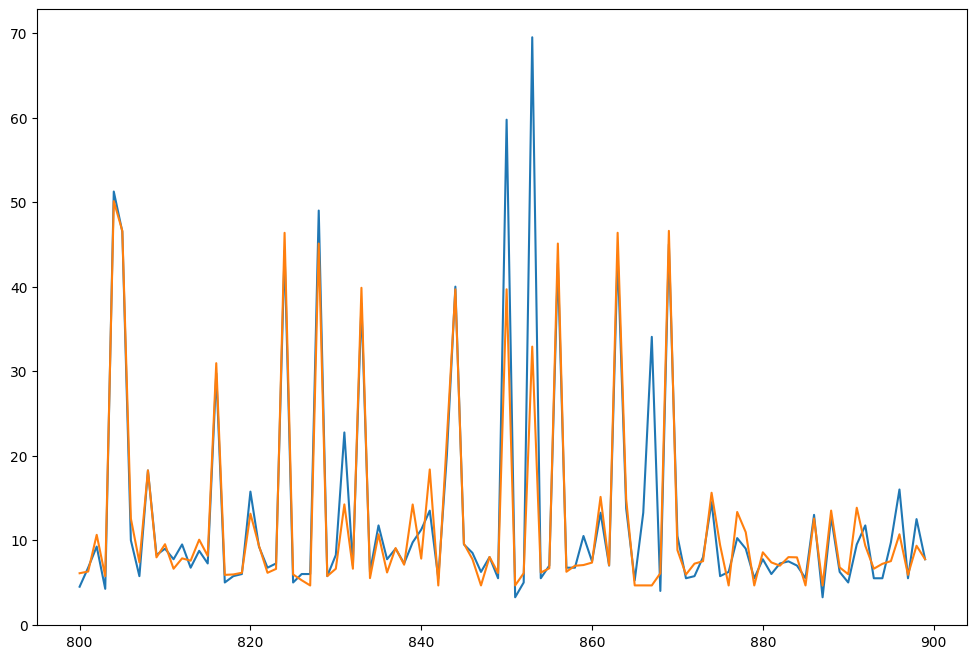

In [33]:
plt.figure(figsize=(12,8))
plt.plot(df_test_svm['Actual test'][800:900], label="A. Test")
plt.plot(df_test_svm['Prediction'][800:900], label="prediction")
plt.show()

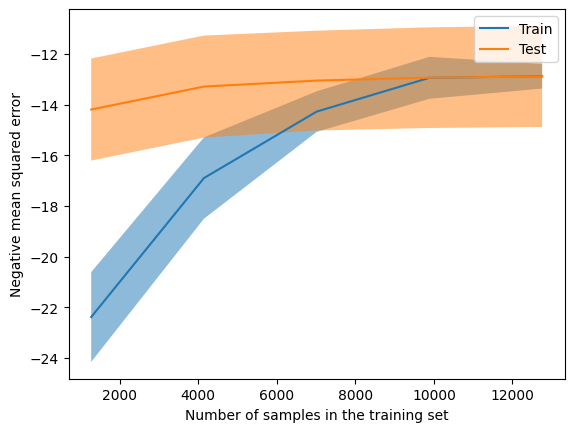

In [34]:
LearningCurveDisplay.from_estimator(svm, X_train, y_train, scoring = 'neg_mean_squared_error')
plt.show()

In [35]:
# param_grid_svm = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 1, 10],
#     'gamma': ['scale', 'auto'],
#     'epsilon': [0.1, 0.01, 0.001]
# }

# svm_model = GridSearchCV(svm, param_grid=param_grid_svm, scoring='neg_mean_squared_error', cv=3, verbose=1)
# svm_model.fit(X_train, y_train)

# best_params = svm_model.best_params_
# svm_model_tuned = SVR(**best_params)
# svm_model_tuned.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
import joblib

# Define the parameter grid
param_grid_svm = {
    'gamma': np.logspace(-3, 3, 7),  
    'epsilon': np.logspace(-2, 2, 5),
    'C': [0.01, 0.1, 1]
}

# Initialize SVR and GridSearchCV
svm_model = GridSearchCV(SVR(), param_grid=param_grid_svm, scoring='neg_mean_squared_error', cv=None, verbose=1, n_jobs=-1)

# Fit the model in parallel using all available CPU cores
with joblib.parallel_backend('threading', n_jobs=-1):
    svm_model.fit(X_train, y_train)

# Get the best parameters and initialize the tuned SVR model
best_params = svm_model.best_params_
svm_model_tuned = SVR(**best_params)

# Fit the tuned model
svm_model_tuned.fit(X_train, y_train)


Fitting 5 folds for each of 105 candidates, totalling 525 fits


SVR(C=1, epsilon=1.0, gamma=0.001)

In [36]:
svm_model_tuned_pred = svm_model_tuned.predict(X_test)
mse = mean_squared_error(svm_model_tuned_pred, y_test)
rmse = root_mean_squared_error(svm_model_tuned_pred, y_test)
mae = mean_absolute_error(svm_model_tuned_pred, y_test)
mape = mean_absolute_percentage_error(svm_model_tuned_pred, y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 31.699559360408447
RMSE: 5.630236172702567
MAE: 2.565243556580125
MAPE: 0.21933043656739534


In [37]:
df_test_tuned_SVR = pd.DataFrame(data={"Actual test":y_test, "Prediction":svm_model_tuned_pred})
df_test_tuned_SVR

,Actual test,Prediction
0,35.00,33.270612
1,3.25,4.575721
2,5.50,8.182727
3,51.50,39.468737
4,14.25,12.553321
...,...,...
3982,12.50,17.359736
3983,3.25,4.605389
3984,5.25,6.309309
3985,8.00,7.999779


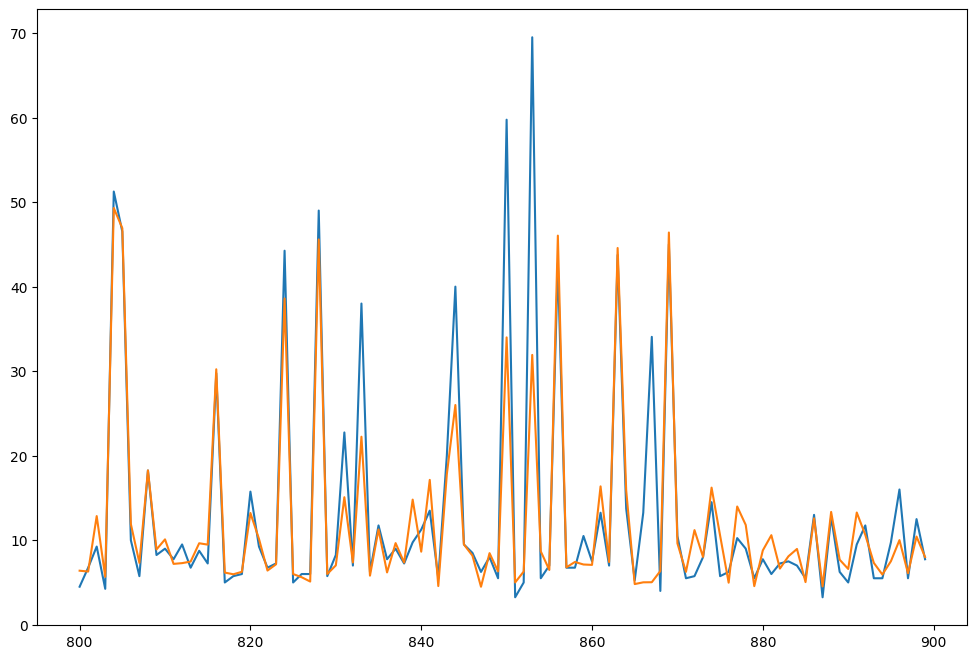

In [38]:
plt.figure(figsize=(12,8))
plt.plot(df_test_tuned_SVR['Actual test'][800:900], label="A. Test")
plt.plot(df_test_tuned_SVR['Prediction'][800:900], label="prediction")
plt.show()

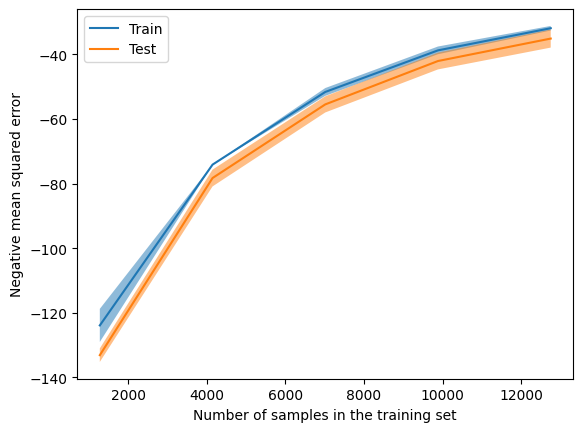

In [39]:
LearningCurveDisplay.from_estimator(svm_model_tuned, X_train, y_train, scoring = 'neg_mean_squared_error')
plt.show()